# How and Why BatchNorm Works - Part 2


In Part 1, we showed how using batch normalization can help train neural networks by reducing internal covariate shift and smoothing gradient updates. We also touch upon the idea that it makes the loss surface smoother and more convex (residual connections have a similar effect).

In their 2018 paper, Santukar et al. argue that internal covariate shift isn't substantially reduced at all. In fact, when additional noise is added to the activations to force covariate shift, batch normalization continues to improve training performance. This is despite no significant reduction in covariate shift. They argue that the major reason for improved performance is the smoother loss surface.

However, we saw in our own experiments using a shallow neural network that the reduction in covariate shift is substantial. Let's get to the bottom of this.

In this experiment, we will start by reproducing the results from Santukar et al. Then we will try and understand why their results and our previous experiment differ.

## Let's start as usual by setting up the dataset
We will use the CIFAR-10 dataset for this experiment.
The CIFAR-10 dataset is a widely used benchmark in machine learning for evaluating image classification algorithms. It consists of 60,000 color images, each sized 32x32 pixels, divided into 10 distinct classes such as airplanes, automobiles, birds, cats, and ships. The dataset is split into 50,000 training images and 10,000 test images, with an equal number of examples per class. Created by the Canadian Institute for Advanced Research, CIFAR-10 is challenging due to its low resolution and high intra-class variability. It serves as a foundational dataset for developing and comparing deep learning models, especially convolutional neural networks (CNNs).

In [3]:
def is_colab():
    try:
        import google.colab
        return True
    except ImportError:
        return False

if is_colab():
    !git clone https://github.com/novastar53/deepkit
    !cd deepkit && git pull && uv build . --wheel && pip uninstall deepkit -y && pip install ./dist/* --quiet


fatal: destination path 'deepkit' already exists and is not an empty directory.
remote: Enumerating objects: 4, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 3 (delta 1), reused 3 (delta 1), pack-reused 0 (from 0)
Unpacking objects: 100% (3/3), 14.09 KiB | 7.05 MiB/s, done.
From https://github.com/novastar53/deepkit
   9fd37b8..5f36bf8  main       -> origin/main
Updating 9fd37b8..5f36bf8
Fast-forward
 uv.lock | 444 ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
 1 file changed, 444 insertions(+)
 create mode 100644 uv.lock
running egg_info
writing src/deepkit.egg-info/PKG-INFO
writing dependency_links to src/deepkit.egg-info/dependency_links.txt
writing requirements to src/deepkit.egg-info/requires.txt
writing top-level names to src/deepkit.egg-info/top_level.txt
reading manifest file 'src/deepkit.egg-info/SOURCES.txt'
adding license file 'LICENSE'
writing manifest file 'src/deepkit.e


## Next, let's set up the model
We'll be using the standard VGG-Net architecture as per the paper.






In [89]:
import jax
import jax.numpy as jnp
import flax.nnx as nnx

kernel_init = nnx.initializers.glorot_normal()


class VGGBlock(nnx.Module):
    def __init__(self, in_features: int, out_features: int, rngs: nnx.Rngs):
        self.conv = nnx.Conv(in_features=in_features,
                             out_features=out_features,
                             kernel_size=(3, 3),
                             kernel_init=kernel_init,
                             padding='SAME',
                             rngs=rngs)
        self.bn = nnx.BatchNorm(num_features=out_features, momentum=0.90, rngs=rngs)

    def __call__(self, x):
        x = self.conv(x)
        conv_activation = x
        x = self.bn(x)
        x = nnx.relu(x)
        return x, conv_activation

class VGGNet(nnx.Module):
    def __init__(self, rngs: nnx.Rngs):
        self.convs = [
            VGGBlock(in_features=3, out_features=64,  rngs=rngs),
            VGGBlock(in_features=64, out_features=64,  rngs=rngs),

            VGGBlock(in_features=64, out_features=128, rngs=rngs),
            VGGBlock(in_features=128, out_features=128, rngs=rngs),

            VGGBlock(in_features=128, out_features=256, rngs=rngs),
            VGGBlock(in_features=256, out_features=256, rngs=rngs),

            VGGBlock(in_features=256, out_features=512, rngs=rngs),
            VGGBlock(in_features=512, out_features=512, rngs=rngs),

            VGGBlock(in_features=512, out_features=512, rngs=rngs),
            VGGBlock(in_features=512, out_features=512, rngs=rngs),
        ]

        self.fc1 = nnx.Linear(in_features=512, out_features=96, kernel_init=kernel_init, rngs=rngs)
        self.fc2 = nnx.Linear(in_features=96, out_features=96, kernel_init=kernel_init, rngs=rngs)
        self.out = nnx.Linear(in_features=96, out_features=10,  kernel_init=kernel_init, rngs=rngs)

    def __call__(self, x):
        activations = {}
        max_pool_after = [1, 3, 5, 7, 9]
        for conv_idx in range(len(self.convs)):
            layer = self.convs[conv_idx]
            x, act = layer(x)
            activations[f"conv_{conv_idx}"] = act
            if conv_idx in max_pool_after:
                x = nnx.max_pool(x, window_shape=(2, 2), strides=(2, 2))

        x = x.squeeze()

        x = self.fc1(x)
        activations["fc1"] = x
        x = nnx.relu(x)

        x = self.fc2(x)
        activations["fc2"] = x
        x = nnx.relu(x)

        x = self.out(x)
        return x, activations

In [90]:
rng_key = jax.random.key(1337)
rngs = nnx.Rngs(rng_key)
candidate = VGGNet(rngs=rngs)
graphdef, state = nnx.split(candidate)
param_counts = sum(jax.tree_util.tree_leaves(jax.tree_util.tree_map(lambda x: x.size, state)))
print(f"Initialized model with {param_counts:,} parameters.")
nnx.display(state)

Initialized model with 9,476,298 parameters.


In [91]:
rng_key = jax.random.key(1337)
rngs = nnx.Rngs(rng_key)
baseline = VGGNet(rngs=rngs)

class Dummy(nnx.Module):
    def __call__(self, x):
        return x


for vgg in baseline.convs:
  vgg.bn = Dummy()
graphdef, state = nnx.split(baseline)
param_counts = sum(jax.tree_util.tree_leaves(jax.tree_util.tree_map(lambda x: x.size, state)))
print(f"Initialized model with {param_counts:,} parameters.")
nnx.display(state)

Initialized model with 9,464,522 parameters.


In [92]:
import optax

lr = 0.1
momentum = 0.9


baseline_opt = optax.chain(optax.clip_by_global_norm(1.0), optax.sgd(learning_rate=lr, momentum=momentum, nesterov=False))
candidate_opt = optax.chain(optax.clip_by_global_norm(1.0), optax.sgd(learning_rate=lr, momentum=momentum, nesterov=False))

baseline_optimizer = nnx.Optimizer(baseline, optax.sgd(learning_rate=lr, momentum=momentum, nesterov=False))
candidate_optimizer = nnx.Optimizer(candidate, optax.sgd(learning_rate=lr, momentum=momentum, nesterov=False))

In [93]:
from functools import partial


def loss_fn(model, batch, targets):
    logits, activations = model(batch)
    loss = optax.softmax_cross_entropy_with_integer_labels(logits, targets).mean()
    return loss, activations

@nnx.jit
def step_fn(model: nnx.Module, optimizer: nnx.Optimizer, batch: jax.Array, labels: jax.Array):
    (loss, activations), grads = nnx.value_and_grad(loss_fn, has_aux=True)(model, batch, labels)
    optimizer.update(grads)
    return loss, activations, grads


@nnx.jit
def accuracy(model: nnx.Module, batch: jax.Array, labels: jax.Array):
    logits, _ = model(batch)
    #probs = nnx.softmax(logits, axis=-1)
    preds = jnp.argmax(logits, axis=-1)
    sum = jnp.sum(preds == labels)
    acc = sum/logits.shape[0]
    return acc


def test_accuracy(model: nnx.Module, testloader):
    acc, n = 0, 0
    for batch, labels in testloader:
        batch = jnp.array(batch)
        labels = jnp.array(labels)
        acc += accuracy(model, batch, labels)
        n += 1
    return acc/n



In [94]:
def grad_norms(grads):
  norms = jax.tree_util.tree_map(lambda x: jnp.linalg.norm(x), grads)
  return norms


import os
import random
import string
import numpy as np
from pathlib import Path

def generate_random_code(length=6):
    return ''.join(random.choices(string.ascii_lowercase, k=length))

class DiskLogger:
    def __init__(self, name, save_dir="./logs"):
        self.run_code = generate_random_code()
        self.save_dir = Path(save_dir) / self.run_code / name
        self.save_dir.mkdir(parents=True, exist_ok=True)
        self.name = name
        self.files = None

    def log(self, step, x):
        file_name = f"{step:05d}.npz"
        file_path = self.save_dir / file_name
        np.savez(file_path, **x)

    def __len__(self):
        return len(os.listdir(self.save_dir))

    def __call__(self):
        if not self.files:
          self.files = sorted([f for f in os.listdir(self.save_dir)])
        for filename in self.files:
          filepath = os.path.join(self.save_dir, filename)
          data = np.load(filepath, allow_pickle=True)
          yield data

    def __getitem__(self, i):
       if not self.files:
        self.files = sorted([f for f in os.listdir(self.save_dir)])
       filepath = os.path.join(self.save_dir, self.files[i])
       data = np.load(filepath, allow_pickle=True)
       return data



In [95]:
num_epochs = 39
num_steps = num_epochs*len(train_loader)

iter: 2660 | baseline loss: 0.8996 | candidate loss: 0.7397 | baseline train acc: 0.82 | candidate train acc: 0.73 | baseline test acc:  0.68 | candidate test acc:  0.72


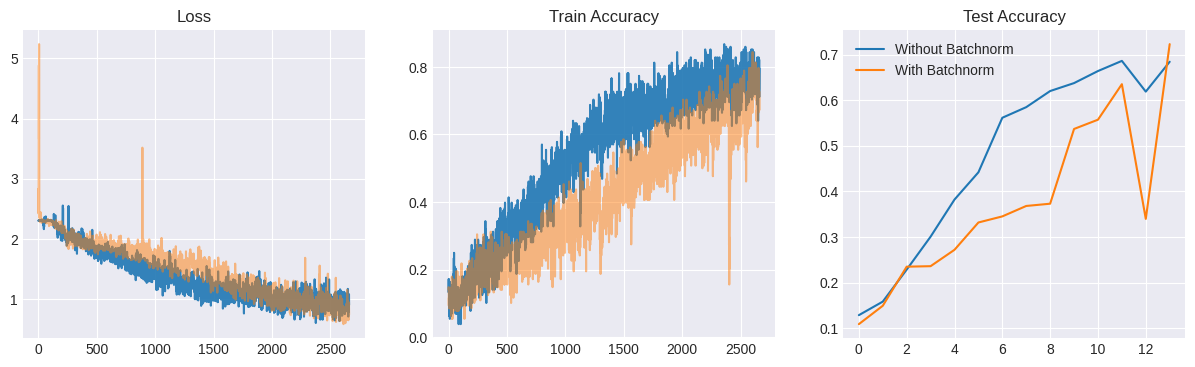

Received KeyboardInterrupt. Exiting...


In [96]:
from matplotlib import pyplot as plt
plt.style.use('seaborn-v0_8-darkgrid')
from IPython.display import clear_output

from deepkit import load_CIFAR10

%matplotlib inline

train_loader, test_loader = load_CIFAR10(augment=False)

baseline.train()
candidate.train()
baseline_train_accs, candidate_train_accs = [], []
baseline_test_accs, candidate_test_accs = [], []
baseline_train_losses, candidate_train_losses = [], []
#baseline_grad_norms, candidate_grad_norms = [], []
#baseline_activations_log, candidate_activations_log = [], []

baseline_activations_logger = DiskLogger("baseline_activations")
candidate_activations_logger = DiskLogger("candidate_activations")

i = 0
try:
  for epoch in range(num_epochs):
      for batch, labels in train_loader:
          batch = jnp.array(batch)
          labels = jnp.array(labels)
          baseline.train()
          candidate.train()
          baseline_loss, baseline_activations, baseline_grads = step_fn(baseline, baseline_optimizer, batch, labels)
          candidate_loss, candidate_activations, candidate_grads = step_fn(candidate, candidate_optimizer, batch, labels)
          baseline_train_losses.append(baseline_loss)
          candidate_train_losses.append(candidate_loss)
          baseline.eval()
          candidate.eval()
          baseline_acc = accuracy(baseline, batch, labels)
          candidate_acc = accuracy(candidate, batch, labels)
          baseline_train_accs.append(baseline_acc)
          candidate_train_accs.append(candidate_acc)
          if i % 200 == 0:
            baseline_test_acc = test_accuracy(baseline, test_loader)
            candidate_test_acc = test_accuracy(candidate, test_loader)
            baseline_test_accs.append(baseline_test_acc)
            candidate_test_accs.append(candidate_test_acc)
            baseline_activations_logger.log(i, baseline_activations)
            candidate_activations_logger.log(i, candidate_activations)
          if i % 20 == 0:
            clear_output(wait=True)
            print(f"iter: {i} | baseline loss: {baseline_loss:0.4f} | candidate loss: {candidate_loss:0.4f} | baseline train acc: {baseline_acc:0.2f} | candidate train acc: {candidate_acc:0.2f} | baseline test acc: {baseline_test_acc: 0.2f} | candidate test acc: {candidate_test_acc: 0.2f}")
            fig, axes = plt.subplots(1, 3, figsize=(15, 4))
            axes[0].plot(baseline_train_losses, alpha=0.9, label="Without BatchNorm")
            axes[0].plot(candidate_train_losses, alpha=0.5, label="With BatchNorm")
            axes[0].set_title("Loss")
            axes[1].plot(baseline_train_accs, alpha=0.9, label="Without BatchNorm")
            axes[1].plot(candidate_train_accs, alpha=0.5, label="With BatchNorm")
            axes[1].set_title("Train Accuracy")
            axes[2].plot(baseline_test_accs, label="Without Batchnorm")
            axes[2].plot(candidate_test_accs, label="With Batchnorm")
            axes[2].set_title("Test Accuracy")
            plt.legend()
            plt.show()

          #print(f"iter: {i} | baseline test acc: {baseline_test_acc: 0.2f} | candidate test acc: {candidate_test_acc: 0.2f}")
          i += 1
except KeyboardInterrupt:
    print("Received KeyboardInterrupt. Exiting...")

In [88]:
from matplotlib import colormaps as cm
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

layers = [f"conv_{i}" for i in range(10)]

fig, axs = plt.subplots(10, 1, figsize=(5,24), constrained_layout=True)


def update(frame):
    baseline_activations = baseline_activations_logger[frame]
    candidate_activations = candidate_activations_logger[frame]
    for layer_idx, layer in enumerate(layers):
        axs[layer_idx].cla()
        layer_baseline_activations = baseline_activations[layer].flatten()
        layer_baseline_mean = layer_baseline_activations.mean()
        layer_baseline_std = layer_baseline_activations.std()
        axs[layer_idx].hist(layer_baseline_activations, color=cm["Blues"](50), bins=60, alpha=1.0)

        layer_candidate_activations = candidate_activations[layer].flatten()
        layer_candidate_mean = layer_candidate_activations.mean()
        layer_candidate_std = layer_candidate_activations.std()
        axs[layer_idx].hist(layer_candidate_activations, color=cm["Reds"](90),  bins=60, alpha=0.5)
        axs[layer_idx].set_title(f"{layer} Outputs - Iteration:{frame}")

        axs[layer_idx].margins(x=0, y=0)
        axs[layer_idx].set_xlim(-8, 8)
        axs[layer_idx].legend([f"Baseline: {layer_baseline_mean:0.2f}, {layer_baseline_std:0.2f}",
                              f"Candidate:{layer_candidate_mean:0.2f}, {layer_candidate_std:0.2f}"])


ani = FuncAnimation(fig, update, frames=len(baseline_activations_logger), interval=300, repeat=True)
plt.close(fig)
video_html = ani.to_html5_video().replace('<video', '<video muted')
HTML(video_html)

CalledProcessError: Command '['ffmpeg', '-f', 'rawvideo', '-vcodec', 'rawvideo', '-s', '500x2400', '-pix_fmt', 'rgba', '-framerate', '3.3333333333333335', '-loglevel', 'error', '-i', 'pipe:', '-vcodec', 'h264', '-pix_fmt', 'yuv420p', '-y', '/tmp/tmpzgioeaty/temp.m4v']' returned non-zero exit status 255.